# Projeto 1 - Ciência dos Dados

Nome: Camila Soares Magni

Nome: Lincoln Rodrigo Pereira Melo

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [26]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [27]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\Lincoln\Desktop\Matérias2021.2\Cdados\LAST\Proj1Cdados


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [28]:
filename = 'airfryer.xlsx'

In [29]:
train = pd.read_excel(filename)
train = train.dropna(axis=1)
train.head(5)

,Treinamento,Classificação
0,o twitter vai me fazer comprar uma airfryer,1
1,"quero assar pão de queijo, mas o forno daqui d...",1
2,"bom, aparentemente deu ruim e saiu toda a tint...",1
3,de airfryer a panelas: polishop celebra 22 ano...,0
4,@danielsmarconn mano eu tô louca nessa airfrye...,1


In [30]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Classificação
0,"o bom da airfryer fica tudo pronto rápido, não...",1
1,um app pra calcular se é mais barato fazer a c...,0
2,@raytotsukishiro aumentou o preço de tudo. aqu...,0
3,meti um pão de queijo na airfryer 😌,1
4,"@alcysio @safbf pô alcysio, me adaptei total p...",1


___
## Classificador automático de sentimento


## SOBRE O PRODUTO

O produto escolhido foi a AirFryer : "AirFryer ou air fryer é um eletrodoméstico usado para fritar alimentos. É tão eficaz quanto uma fritadeira tradicional que usa óleo, mas não utiliza a imersão em gorduras para a cocção/para o cozimento dos alimentos."

fonte : https://pt.wikipedia.org/wiki/Fritadeira_sem_%C3%B3leo

Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

A partir da escolha do produto, foram considerados relevantes os tweets que expressam algum sentimento, seja positivo ou negativo, além de mensagens que demonstram vontade de adquirir o produto ou receitas que os usuários compartilham.
O restante dos tweets foi considerado irrelevante, incluindo aqueles que utilizam o termo "airfryer" em outros contextos não relacionados diretamente ao produto (Por exemplo, "Parece que estou dentro de uma airfryer").


___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

O classificador multinomial Naïve Bayes é um dos modelos mais populares no aprendizado de máquina. Tomando como premissa a suposição de independência entre as variáveis do problema, o modelo de Naïve Bayes realiza uma classificação probabilística de observações, caracterizando-as em classes pré-definidas. 


O algoritmo Naïve Bayes é uma aplicação direta do teorema homônimo. O termo naïve, (do inglês, ingênuo) se refere à premissa central do algoritmo de que os atributos considerados são não correlacionados entre si. 

fonte : https://www.digitalhouse.com/br/blog/naive-bayes


Por exemplo, no classificador aqui montado, não são levada em contas expressões e apenas as palavras isoladas.


Explicando um pouco da construção do classificador:

#### Eventos:
$R$:   tweets relevantes

$R^C$: tweets irrelevantes

$U$ :  todos os tweets relacionados com airfryer coletados

$P(R)$ -> Probabilidade de um tweet ser relevante

$P(R^C)$ -> Probabilidade de um tweet ser irrelevante

$P(R/Tweet)$ -> Probabilidade de ser relevante dado que é um tweet relacionado com airfryer

$P(R^C/Tweet)$ -> Probabilidade de ser irrelevante dado que é um tweet relacionado com airfryer

Lembre-se que $P(A/B) = P(B/A) * P(A) / P(B)$

Note que ao utilizar Naive-Bayes, queremos apenas classificar como relevante ou irrelevante, ou seja 
saber se P(R/Tweet) > P(R^C/Tweet) ou P(R^C/Tweet) > P(R/Tweet):
Se calcularmos :
$P(R/Tweet) = P(Tweet/R) * P(R) / P(Tweet)$   (i)

e

$P(R^C/Tweet) = P(Tweet/R^c) * P(R^c) / P(Tweet)$ (ii)

Como queremos apenas a comparação entre (i) e (ii), podemos desconsiderar os denominadores na conta
Portanto, para esse caso usaremos:

$P(R/Tweet) = P(Tweet/R) * P(R)$

$P(R^C/Tweet) = P(Tweet/R^c) * P(R^c)$

Com isso, olhando para a $P(Tweet/R) e P(Tweet/R^c).$

Considerando Tweet = palavra1 palavra2 palavra3

A nossa $P(Tweet/R) = P(palavra1/R) * P(palavra2/R) * P(palavra3/R)$

e 
$P(Tweet/R^C) = P(palavra1/R^C) * P(palavra2/R^C) * P(palavra3/R^C)$

### Suavização de LaPlace:

Seguindo a linha de raciocínio de Naive-Bayes, caso uma palavra não esteja presente no conjunto de palavras analisados, então teríamos:

$P(palavra/R)$ = 0

e

$P(palavra/R^C)$ = 0.

Portanto se essa palavra estivesse em qualquer frase, a probabilidade dessa frase ser classificada seria zero.

Para resolver essa situação surgiu a Suavização de Laplace. Essa ideia se baseia em adicionar um em cada contagem para que o resultado do numerador nunca seja igual a zero. Além disso, adicionar o número de palavras possíveis no denominador para balancear e garantir que a divisão nunca vai ser maior do que 1.

Note que essa ideia será aplicada na implementação da função.

### Funções para a limpeza da base de dados:

In [31]:
import pandas as pd
import numpy as np
from IPython.display import display
import re 
import nltk

# Função de limpeza dos textos
def cleanup(text):
    punctuation = '[""''!-.:?;“”~1234567890]'                            # sinais que queremos retirar do texto
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)                              # retira os sinais
    text_subbed = re.sub(r"http\S+", "", text_subbed)                    # retira os URL
    text_subbed = re.sub('@[^\s]+','',text_subbed,flags=re.MULTILINE)    # retira os nomes de usuário
    text_subbed = re.sub(r"kk\S+", "kk", text_subbed)                    # transforma as strings que começam com kk em 'kk'
    text_subbed = re.sub(r"compr\S+", "compr", text_subbed)              # transforma as strings que começam com compr (radical do verbo comprar) em "compr"
    text_subbed = re.sub(r"limp\S+", "limp", text_subbed)                # transforma as strings que começam com limp (radical do verbo limpar) em "limp"
    text_subbed = re.sub(r"aa\S+", "", text_subbed)                      # retira as strings que começam com aa (normalmente alguma expressão ou sequência de letras sem sentido)
    text_subbed = re.sub(r"airfryer\S+", "airfryer", text_subbed)        # usado evitar que erros de escrita de palavras coladas com airfryer não acontecam
    text_subbed = re.sub(r"queij\S+", "queij", text_subbed)              # para corrigir alguns erros de português comuns dos usuários dos tweets (receita recorrente)
    text_subbed = re.sub(r"batat\S+", "batata", text_subbed)             # transforma as strings que começam com batat (radical da palavra batata) para evitar variações como "Batatinhas"
    aux = nltk.TweetTokenizer()
    text_subbed = aux.tokenize(text_subbed)                              # separa os emojis
    string_final = ' '.join(text_subbed)                                 # string limpa
    return string_final

In [32]:
# Função para tirar as 'Stopwords' em português:
# nltk.download('stopwords') - INSTALAR, caso vc não tenha instalado
def retirar_stopwords(lista):
    lista_limpa = []
    stopwords = nltk.corpus.stopwords.words('portuguese')
    for palavra in lista:
        if palavra not in stopwords:
            lista_limpa.append(palavra)
    return lista_limpa

### Realizando a limpeza da base de treinamento

In [33]:
lista = []
for linha in train['Treinamento']:
    limpo = cleanup(linha.lower())             # Limpa a planilha Treinamento e tira as letras maiúsculas 
    a = limpo.split()
    b = retirar_stopwords(a)
    limpo = ' '.join(b)  
    lista.append(limpo)
    
serie_train = pd.Series(lista)                 # Transforma a coluna da planilha Treinamento em Series
train['Treinamento'] = serie_train        # substitui os tweets originais da planilha, pelos tweets limpos


# Função Classificadora Naive-Bayes

Na Célula abaixo está implementada a função classificadora Naive-Bayes

In [34]:
def classificador(dataframe, series):                         #recebe o dataframe e a serie de tweets que será classificada
    
    filtro = train.Classificação==1          # filtra os tweets classificados como relevantes
    relevantes = train.loc[filtro, :]        # dataframe com tweets relevantes

    filtro2 = train.Classificação==0        # filtra os tweets classificados como irrelevantes
    irrelevantes = train.loc[filtro2, :]    # dataframe com tweets irrelevantes

    # Transforma o dataframe relevantes em um único texto
    string_relevante = ''
    for linha in relevantes.iloc[:,0]:
        string_relevante+= ' '+ linha

    # Transforma o dataframe irrelevantes em um único texto
    string_irrelevante = ''
    for linha in irrelevantes.iloc[:,0]:
        string_irrelevante+= ' '+ linha

    todas_relevantes = string_relevante.split()        #Lista com todas as palavras que aparece na string relevante
    todas_irrelevantes = string_irrelevante.split()    #Lista com todas as palavras que aparece na string irrelevante

    serie_relevante = pd.Series(todas_relevantes)      #Transforma a lista de strings relevantes em um series
    serie_irrelevante = pd.Series(todas_irrelevantes)  #Transforma a lista de strings irrelevantes em um series

    todas = string_irrelevante + string_relevante          # juntando todas as palavras que aparecem na base de dados Treinamento
    todas_as_palavras = todas.split()                      # lista com todas as palavras
    serie_total = pd.Series(todas_as_palavras) 
    serie_total

    P_R = len(todas_relevantes)/len(todas_as_palavras)        # probabilidade de uma palavra ser relevante
    P_I = len(todas_irrelevantes)/len(todas_as_palavras)      # probabilidade de uma palavra ser irrelevante

    freq_rel_absoluta = serie_relevante.value_counts()           # quantidade de cada palavra na serie relevante
    freq_irrel_absoluta = serie_irrelevante.value_counts()       # quantidade de cada palavra na serie irrelevante
    freq_tot_absoluta = serie_total.value_counts()               # quantidade de cada palavra na serie total


    
    classificados = []
    for frase in series:
        lista_palavras = frase.split()
        lista_palavras = retirar_stopwords(lista_palavras)    #implementa função que tira as stopwords
        k,i = 0,0                                             #contador de palavras NÃO presentes em relevantes (k) e em irrevelantes (i)
        for palavra in lista_palavras:
            if palavra not in todas_relevantes: 
                k += 1
            if palavra not in todas_irrelevantes:
                i += 1

        prob_frase_dado_relevante = 1
        prob_frase_dado_irrelevante = 1

        if k == 0:                                   #se tiver palavras no series que não estao na nossa base de dados relevantes
            for palavra in lista_palavras:
                prob = freq_rel_absoluta[palavra] / freq_rel_absoluta.sum()
                prob_frase_dado_relevante *= prob           #multiplica a probabilidade de cada palavra dado frase

        else:
            for palavra in lista_palavras:
                if palavra in freq_rel_absoluta:
                    prob = (freq_rel_absoluta[palavra]+ 1 ) / (freq_rel_absoluta.sum()+ len(freq_tot_absoluta)) # SUAVIZAÇÃO DE LAPLACE"
                else: 
                    prob = (0 + 1 ) / (freq_rel_absoluta.sum()+ len(freq_tot_absoluta))
                prob_frase_dado_relevante *= prob           #multiplica a probabilidade de cada palavra dado frase
        
        if i == 0:
            for palavra in lista_palavras:
                prob = ( freq_irrel_absoluta[palavra] ) / (freq_irrel_absoluta.sum())
                prob_frase_dado_irrelevante *= prob     

        else:
            for palavra in lista_palavras:
                if palavra in freq_irrel_absoluta:
                    prob = ( freq_irrel_absoluta[palavra]+ 1 ) / (freq_irrel_absoluta.sum() +len(freq_tot_absoluta))
                else:
                    prob = ( 0 + 1 ) / (freq_irrel_absoluta.sum() +len(freq_tot_absoluta))
                prob_frase_dado_irrelevante *= prob         #multiplica a probabilidade de cada palavra dado frase
                #multiplica a probabilidade de cada palavra dado frase
                
        probRdadoFrase = prob_frase_dado_relevante* P_R
        probIdadoFrase = prob_frase_dado_irrelevante* P_I
        
        if probRdadoFrase > probIdadoFrase:
            classificados.append(1)                         #classifica como relevante
        else:  
            classificados.append(0)                         #classifica como irrelevante
    
    serie_classificado = pd.Series(classificados)
    novo_df = dataframe.iloc[:, [0,1]]
    novo_df = novo_df.reset_index(drop=True)
    novo_df['Classificado'] = serie_classificado
    return novo_df
                

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

### Fazendo a limpeza na base de teste

In [35]:
lista = []

for linha in test['Teste']:
    limpo = cleanup(linha.lower())             # Limpa a planilha Teste e tira as letras maiúsculas
    a = limpo.split()
    b = retirar_stopwords(a)
    limpo = ' '.join(b)  
    lista.append(limpo)

test['Teste'] = pd.Series(lista)             # Substitui os tweets originais da planilha, pelos tweets limpos

# Implementando a função...

In [36]:
df = test               # dataframe que será argumento da função classificadora
series= test['Teste']   # series que será argumento da função classificadora

In [37]:
# Implementa função
df = classificador(df, series) #dataframe que passou pelo função para classificar os tweets
df.head()

,Teste,Classificação,Classificado
0,bom airfryer fica tudo pronto rápido quero out...,1,1
1,app pra calcular barato fazer comida airfryer ...,0,1
2,aumentou preço tudo aqui gente compr airfryer ...,0,0
3,meti pão queij airfryer 😌,1,1
4,pô alcysio adaptei total pra usar mínimo gás a...,1,1


## Extraindo as contagens para verificação de performance

In [38]:
tabela = pd.crosstab(df.Classificado, df.Classificação, normalize= True)  # tabela de porcentagens
tabela

Classificação,0,1
Classificado,,
0,0.28,0.095
1,0.17,0.455


Porcentagem de verdadeiros positivos (mensagens relevantes e que são
classificadas como relevantes)

In [39]:
verdadeiros_positivos = tabela.iloc[1,1]*100
verdadeiros_positivos

45.5

Porcentagem de falsos positivos (mensagens irrelevantes e que são classificadas
como relevantes)

In [40]:
falsos_positivos = tabela.iloc[1,0]*100
falsos_positivos

17.0

Porcentagem de verdadeiros negativos (mensagens irrelevantes e que são
classificadas como irrelevantes)

In [41]:
verdadeiros_negativos = tabela.iloc[0,0]*100
verdadeiros_negativos

28.000000000000004

Porcentagem de falsos negativos (mensagens relevantes e que são classificadas
como irrelevantes)

In [42]:
falsos_negativos = tabela.iloc[0,1]*100
falsos_negativos

9.5

Acurácia (mensagens corretamente classificadas, independente da categoria)

In [43]:
acuracia = verdadeiros_positivos + verdadeiros_negativos
acuracia

73.5

___
### Concluindo

#### Performance do classificador e possíveis melhorias  

Comparativo qualitativo sobre os percentuais obtidos:

A partir dos percentuais de verdadeiros positivos e negativos obtidos, observa-se que o nosso classificador possui acurácia de 73.5%, o que significa que dos 100% dos tweets, teríamos 26.5% de falhas (falsos positivos e negativos).

Analisando de maneira mais aprofundada todos os tweets classificados como relevantes (62.5% do total), temos que a porcentagem de verdadeiros positivos (45.5%) é mais que o dobro do que a de falsos positivos (17%). Em outras palavras, 72.8% dos tweets classificados como relevantes, foram classificados corretamente. 

Da mesma forma, olhando para os tweets classificados como irrelevantes (37.5% do total, temos 28% de acertos, ou seja, 74,6% dos tweets classificados como irrelevantes.

As mensagens com sarcasmo ou dupla negação são tratadas pelo classificador da mesma forma que qualquer outra mensagem, isto é, pela análise das probabilidades de cada palavra do tweet. Então, algumas são classificadas corretamente e outras, não, já que muitas palavras aparecem na Base de Treinamento como relevantes. 

Dessa forma, levando em consideração os percentuais obtidos, consideramos que a performance do nosso classificador está aceitável, porém há algumas melhorias que poderiam ser implementadas, como a ideia trazida no artigo "Melhorando a Performance do Algoritmo Naive Bayes para Regressão Através da Combinação de Atributos " de Aloísio Carlos de Pina e de Gerson Zaverucha. Eles trazem uma ideia de  testar combinações de atributos dentro do clássico Naive Bayes, onde transformariam os atributos A1 e A2 em um único atributo C' e caso houvesse melhora utilizando esse novo atributo C' ele seria mantido. Trazendo para a situação do projeto, seria a ideia de testar todas as possíveis combinações de duas palavras e aquelas que melhorassem o desempenho do nosso classificador seria mantida.





fonte : https://www.cos.ufrj.br/~ines/enia07_html/pdf/28095.pdf




#### Por que continuar financiando o projeto? 

O projeto deve continuar sendo financiado, porque a partir dele, é possível entender os interesses e as opiniões do público alvo da empresa, assim como elogios e críticas ao produto, para que seja possível implementar melhorias em pontos com maiores reclamações.

#### Por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets?

Se nós alimentarmos a base de Treinamento utilizando o próprio classificador, o percentual de erros aumentaria significativamente. Isso porque, os erros do classificador se propagariam para a classificação da base Treinamento, que por sua vez, alimentaria a classificação de novas bases, propagando cada vez mais os erros, o que tornaria o modelo cada vez mais impreciso

#### Diferentes cenários de uso para o classificador Naive-Bayes 

O classificador Naive-Bayes pode ser aplicado em diversas situações diferentes, como no diagnóstico de doenças ( Considerando os verdadeiros (positivos e negativos) e falsos (positivos e negativos) , na identificação de mensagens de spam nos emails, protegendo os usuários de um possível golpe e otimizando o tempo passado no email e  numa alimentação de um algoritmo para sugerir conteúdo baseado nas palavras buscadas pelo usuário.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [44]:
test = pd.read_excel(filename, sheet_name = "Teste" )
test_novo_tudo = test.rename(columns={ "Teste" : "Tudo"})

train = pd.read_excel(filename,sheet_name = "Treinamento")
train_novo_tudo = train.rename(columns={ "Treinamento" : "Tudo" })

df_tudo = pd.concat([train_novo_tudo,test_novo_tudo])
df_tudo = df_tudo.dropna(axis=1)
df_tudo

,Tudo,Classificação
0,o twitter vai me fazer comprar uma airfryer,1
1,"quero assar pão de queijo, mas o forno daqui d...",1
2,"bom, aparentemente deu ruim e saiu toda a tint...",1
3,de airfryer a panelas: polishop celebra 22 ano...,0
4,@danielsmarconn mano eu tô louca nessa airfrye...,1
...,...,...
195,tutorial bolinha de queijo✨\n\n200g de queijo ...,1
196,pessoal daqui de casa inventou de querer fazer...,1
197,"eu nao sei voces, mas eu ganhei uma airfryer g...",1
198,@ibebelly amanhã eu vou fazer um pão de alho d...,1


In [45]:
lista = []

for linha in df_tudo['Tudo']:
    limpo = cleanup(linha.lower())             # Limpa a planilha Treinamento e tira as letras maiúsculas 
    a = limpo.split()
    b = retirar_stopwords(a)
    limpo = ' '.join(b) 
    lista.append(limpo)
    
serie = pd.Series(lista)                 # Transforma a coluna da planilha Treinamento em Series
df_tudo['Tudo'] = serie

df_tudo.head()

,Tudo,Classificação
0,twitter vai fazer compr airfryer,1
1,quero assar pão queij forno daqui casa bosta p...,1
2,bom aparentemente deu ruim saiu toda tinta / t...,1
3,airfryer panelas polishop celebra anos descont...,0
4,mano tô louca nessa airfryer serase boa,1


In [46]:
from sklearn.model_selection import train_test_split
def separa_dataframe(df):
    train, test_new = train_test_split(df_tudo, test_size=200)
    return train, test_new

In [47]:
lista_da_acuracia = []

for i in range(100):
    
    datas = separa_dataframe(df_tudo)
    train = datas[0]
    test_new = datas[1]
    df = classificador(test_new, test_new["Tudo"])
    tabela_nova = pd.crosstab(df.Classificado, df.Classificação, normalize= True)
    acuracia = tabela_nova.iloc[1,1]*100 + tabela_nova.iloc[0,0]*100
    lista_da_acuracia.append(acuracia)
    

In [48]:
serie_acuracia = pd.Series(lista_da_acuracia)
minimo = serie_acuracia.min()
maximo = serie_acuracia.max()
media = serie_acuracia.mean()


print('O mínimo de eficácia: {0:.2f} %'.format(minimo))
print('O máximo de eficácia: {0:.2f} %'.format(maximo))
print('A média de eficácia: {0:.2f} %'.format(media))

O mínimo de eficácia: 50.50 %
O máximo de eficácia: 64.50 %
A média de eficácia: 57.34 %


### Histograma com percentuais de acertos

Text(0.5, 0, 'Porcentagem de acertos(%)')

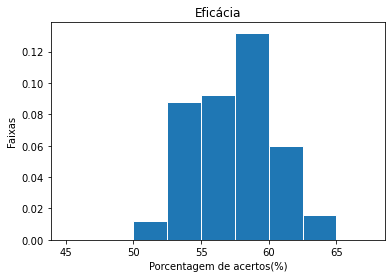

In [50]:
from numpy import arange
import numpy as np
faixa1 = arange(int(minimo)-5,int(maximo)+5,2.5)
faixa1


plt.hist(serie_acuracia, bins=faixa1, edgecolor='white', density = True)
plt.title('Eficácia')
plt.ylabel('Faixas')
plt.xlabel('Porcentagem de acertos(%)')


##### Vantagens ou desvantagens sobre construir um classificador considerando uma única vez a divisão da base de dados em treinamento e em teste:


Analisando o histograma das acurárias obtidas a partir de várias bases de dados, percebe-se que há uma amplitude de 15% entre os valores máximo e mínimo de acurácia. Se tivéssemos considerado essas novas bases de dados na construção do classificador, haveria uma propagação de erros e assim, a confiabilidade do modelo seria prejudicada. Além disso, trabalhar com apenas uma base de dados de treinamento pode ser vantajoso por ser mais fácil encontrar os erros mais frequentes do classificador.

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis
* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**